# Beverages retail sales Forecasting

**Background** 

The dataset was provided by a large beverage company in Australia. They sell their products through various supermarkets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed a forecast of each of the products (6 products in total) at item level every week in weekly buckets.

**Area of Investigation**

1. Trend
2. Seasonality
3. Serial dependence
4. Machine Learning on the time series data

## 1. Data Understanding and Preparation

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
import statsmodels.api as sm
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import datetime
import math
import warnings
warnings.filterwarnings('ignore')

In [192]:
df = pd.read_csv('retail_data.csv')

In [193]:
df.shape

(1218, 12)

In [194]:
df.head()

Product       date  Sales Price Discount (%)  In-Store Promo  \
0    SKU1   2/5/2017  27750                 0%               0   
1    SKU1  2/12/2017  29023                 0%               1   
2    SKU1  2/19/2017  45630                17%               0   
3    SKU1  2/26/2017  26789                 0%               1   
4    SKU1   3/5/2017  41999                17%               0   

   Catalogue Promo  Store End Promo  Google_Mobility  Covid_Flag  V_DAY  \
0                0                0       0.00000000           0      0   
1                0                1       0.00000000           0      1   
2                0                0       0.00000000           0      0   
3                0                1       0.00000000           0      0   
4                0                0       0.00000000           0      0   

   EASTER  CHRISTMAS  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0

### 1.1 Check data types

In [195]:
df.dtypes

Product                object
date                   object
Sales                   int64
Price Discount (%)     object
In-Store Promo          int64
Catalogue Promo         int64
Store End Promo         int64
Google_Mobility       float64
Covid_Flag              int64
V_DAY                   int64
EASTER                  int64
CHRISTMAS               int64
dtype: object

In [196]:
df['date'] = pd.to_datetime(df['date'])

In [197]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)            object
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [198]:
df['Price Discount (%)'] = [x.replace('%', '') for x in df['Price Discount (%)']]
df['Price Discount (%)'] = df['Price Discount (%)'].astype('int64')

In [199]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

All data types are correct

### 1.2 Check missing values

In [200]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Product               0
date                  0
Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

No missing values were found

### 1.3 Rename the columns

In [201]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df = df.rename(columns = {'In-Store_Promo' : 'In_Store_Promo'})
df.columns

Index(['Product', 'date', 'Sales', 'Price_Discount_(%)', 'In_Store_Promo',
       'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag',
       'V_DAY', 'EASTER', 'CHRISTMAS'],
      dtype='object')

### 1.4 Check for outliers

<Axes: xlabel='Sales', ylabel='Product'>

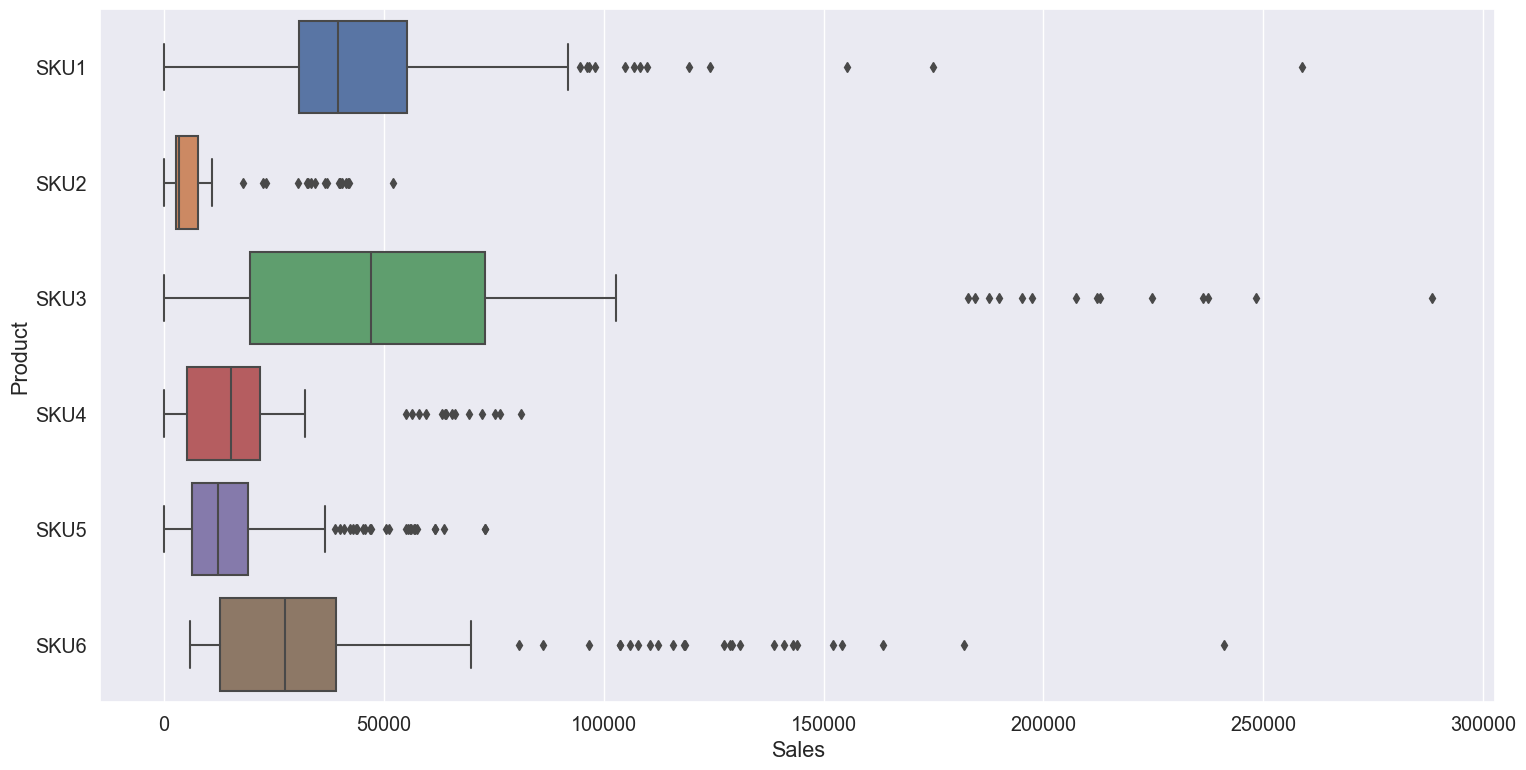

In [202]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

According to the graphs, there are products with `Sales` equals to zero. It is believed that the data needed to be predicted is mixed into the data set after checking the data.

In [203]:
# Separate the test data
df_test = df[df.Sales == 0]

It is noticed that the tested data of SKU6 is missing. 

In [204]:
# remove the 0 Sales rows
df = df.drop(df[df.Sales == 0].index)

<Axes: xlabel='Sales', ylabel='Product'>

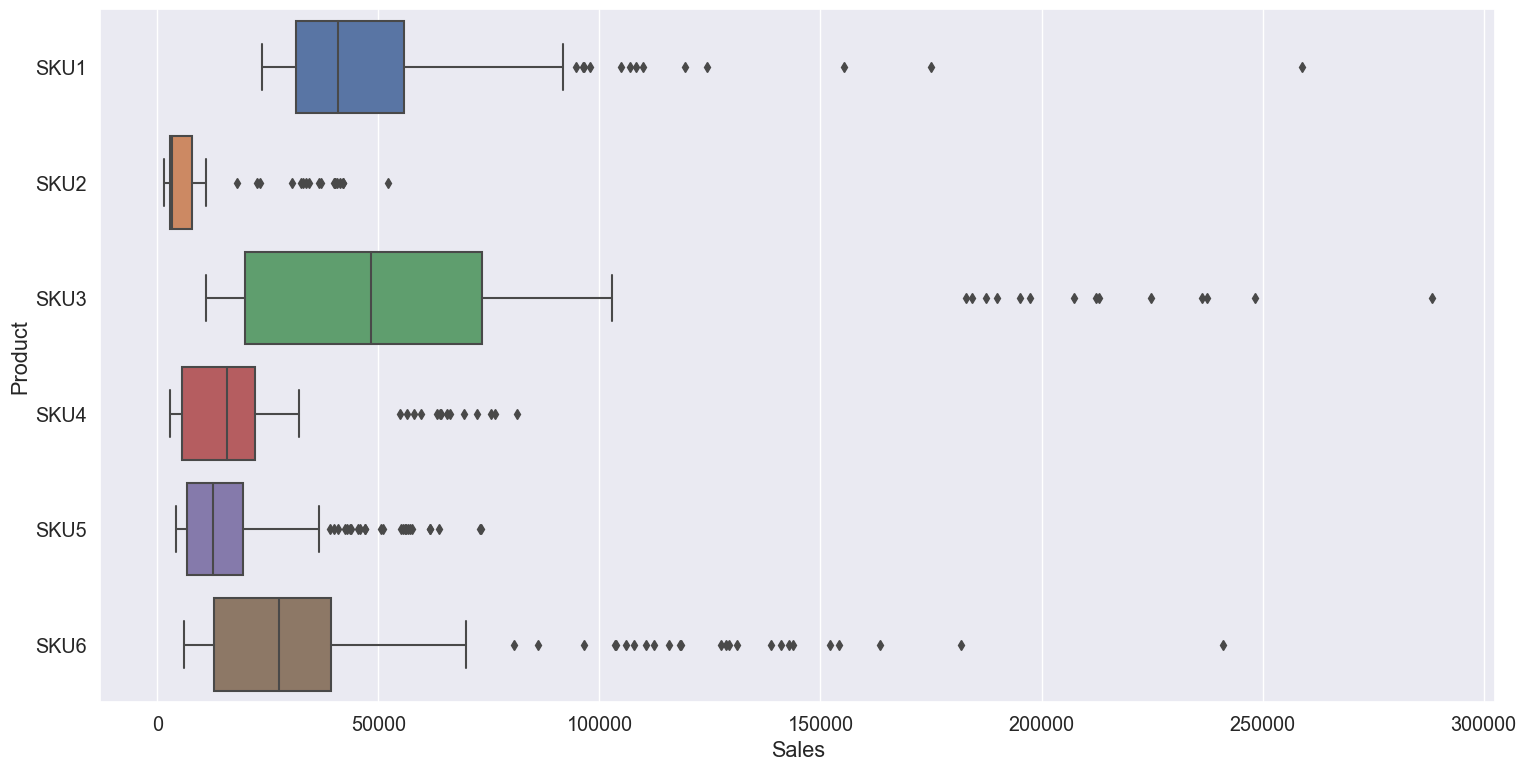

In [205]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

After removing the `Sales` equal to zero, there are still some outliers in the `Sales` feature. But since we do not have enough information on the components for the sales, it is not appropriate to treat it as an outlier.

## 2. Exploratory Data Analysis

### 2.1 Data description

In [206]:
round(df.describe(),2)

date           Sales  Price_Discount_(%)  \
count                 1188   1188.00000000       1188.00000000   
mean   2018-12-26 12:00:00  31059.70000000         24.71000000   
min    2017-02-05 00:00:00   1453.00000000          0.00000000   
25%    2018-01-14 00:00:00   7695.25000000          2.00000000   
50%    2018-12-26 12:00:00  20547.00000000         25.00000000   
75%    2019-12-08 00:00:00  40978.00000000         40.00000000   
max    2020-11-15 00:00:00 288322.00000000         83.00000000   
std                    NaN  35135.66000000         21.32000000   

       In_Store_Promo  Catalogue_Promo  Store_End_Promo  Google_Mobility  \
count   1188.00000000    1188.00000000    1188.00000000    1188.00000000   
mean       0.47000000       0.21000000       0.35000000      -2.28000000   
min        0.00000000       0.00000000       0.00000000     -28.49000000   
25%        0.00000000       0.00000000       0.00000000       0.00000000   
50%        0.00000000       0.00000000       0.00000000       0.00000000   
75%        1.00000000       0.00000000       1.00000000       0.00000000   
max        1.00000000       1.00000000       1.00000000       3.90000000   
std        0.50000000       0.41000000       0.48000000       5.84000000   

         Covid_Flag         V_DAY        EASTER     CHRISTMAS  
count 1188.00000000 1188.00000000 1188.00000000 1188.00000000  
mean     0.21000000    0.02000000    0.02000000    0.02000000  
min      0.00000000    0.00000000    0.00000000    0.00000000  
25%      0.00000000    0.00000000    0.00000000    0.00000000  
50%      0.00000000    0.00000000    0.00000000    0.00000000  
75%      0.00000000    0.00000000    0.00000000    0.00000000  
max      1.00000000    1.00000000    1.00000000    1.00000000  
std      0.41000000    0.14000000    0.14000000    0.12000000

### 2.2 Data visualisation

In [207]:
df = df.set_index('date')

In [208]:
df['Product'].unique()

array(['SKU1', 'SKU2', 'SKU3', 'SKU4', 'SKU5', 'SKU6'], dtype=object)

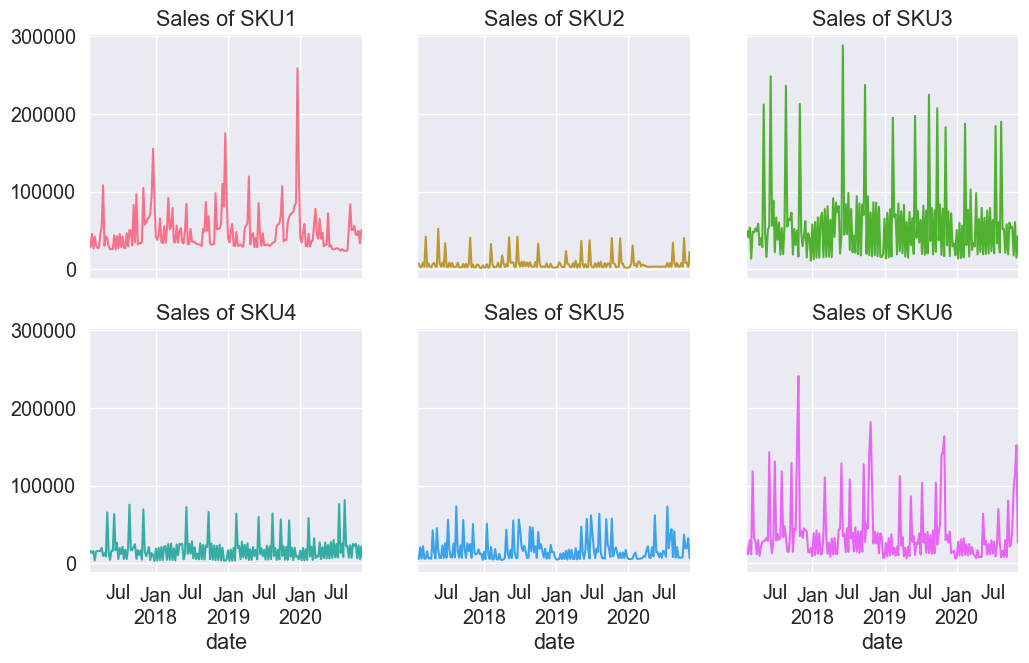

In [209]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7), sharex = True, sharey = True)
palette = sns.color_palette("husl", n_colors=df['Product'].nunique())

for i, c in enumerate(palette):
    product_name = f"SKU{str(i+1)}"
    df.query('Product == @product_name') \
        .Sales \
        .plot(ax = ax[i // 3][i % 3], color = c, title = f"Sales of {product_name}")
    


### 2.3 Correlation

In [210]:
df_corr = df.corr(numeric_only=True)
df_corr

Sales  Price_Discount_(%)  In_Store_Promo  \
Sales               1.00000000          0.43288693      0.25207070   
Price_Discount_(%)  0.43288693          1.00000000      0.22542907   
In_Store_Promo      0.25207070          0.22542907      1.00000000   
Catalogue_Promo    -0.12439792         -0.09149157     -0.48872817   
Store_End_Promo     0.23481125          0.23446402      0.36741030   
Google_Mobility     0.04488454         -0.20749107      0.06047081   
Covid_Flag         -0.04774825          0.26512039     -0.03887343   
V_DAY              -0.01165302         -0.04295289      0.02095091   
EASTER             -0.01349455          0.00364036      0.02095091   
CHRISTMAS          -0.01389265         -0.03516316      0.02154955   

                    Catalogue_Promo  Store_End_Promo  Google_Mobility  \
Sales                   -0.12439792       0.23481125       0.04488454   
Price_Discount_(%)      -0.09149157       0.23446402      -0.20749107   
In_Store_Promo          -0.48872817       0.36741030       0.06047081   
Catalogue_Promo          1.00000000       0.12477784       0.07520178   
Store_End_Promo          0.12477784       1.00000000       0.08250112   
Google_Mobility          0.07520178       0.08250112       1.00000000   
Covid_Flag              -0.09838079      -0.06766677      -0.76437580   
V_DAY                   -0.04546569       0.01948886       0.07639164   
EASTER                  -0.04546569      -0.06821100      -0.11186864   
CHRISTMAS                0.03646811       0.00961972       0.04844984   

                    Covid_Flag       V_DAY      EASTER   CHRISTMAS  
Sales              -0.04774825 -0.01165302 -0.01349455 -0.01389265  
Price_Discount_(%)  0.26512039 -0.04295289  0.00364036 -0.03516316  
In_Store_Promo     -0.03887343  0.02095091  0.02095091  0.02154955  
Catalogue_Promo    -0.09838079 -0.04546569 -0.04546569  0.03646811  
Store_End_Promo    -0.06766677  0.01948886 -0.06821100  0.00961972  
Google_Mobility    -0.76437580  0.07639164 -0.11186864  0.04844984  
Covid_Flag          1.00000000  0.01521270  0.01521270 -0.06338484  
V_DAY               0.01521270  1.00000000 -0.02061856 -0.01781035  
EASTER              0.01521270 -0.02061856  1.00000000 -0.01781035  
CHRISTMAS          -0.06338484 -0.01781035 -0.01781035  1.00000000

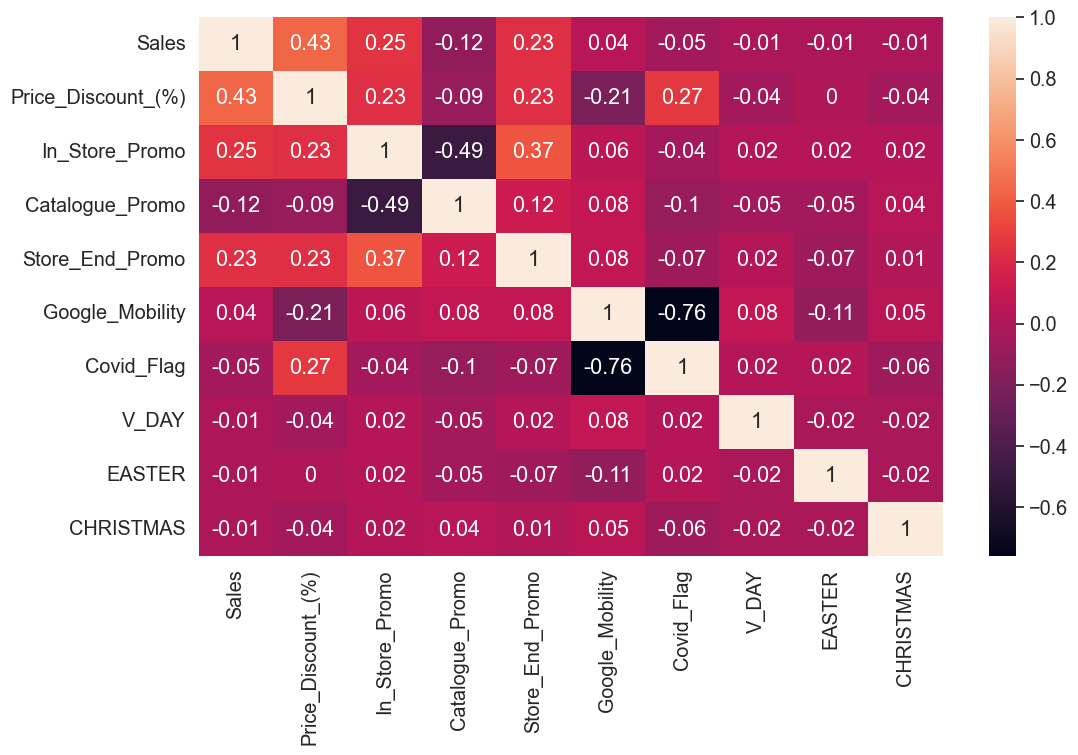

In [211]:
fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(data = round(df_corr, 2),
           annot =True)

From the heatmap, we see that `Google_Mobility` has an inverse correlation with `Covid_Flag`. `In_Store_Promo` is slightly correlated with `Catalogue_Promo` and also for `Sales` and `Price_Discount_(%)`. 

### 2.4 Seasonal Decomposition


In [212]:
# Split the 6 SKUs to different dataset
df_group = df.reset_index().groupby('Product')

# save them in dictionary
skus = {'sku1' : df_group.get_group("SKU1").set_index('date'),
    'sku2' : df_group.get_group("SKU2").set_index('date'),
    'sku3' : df_group.get_group("SKU3").set_index('date'),
    'sku4' : df_group.get_group("SKU4").set_index('date'),
    'sku5' : df_group.get_group("SKU5").set_index('date'),
    'sku6' : df_group.get_group("SKU6").set_index('date')}


In [213]:
def seasonal_decompose(y, axes, i, key):
    res = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    res.observed.plot(ax=axes[0+i*4], legend=False, title = key.upper())
    axes[0+i*4].set_ylabel('Observed')
    res.trend.plot(ax=axes[1+i*4], legend=False)
    axes[1+i*4].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2+i*4], legend=False)
    axes[2+i*4].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3+i*4], legend=False)
    axes[3+i*4].set_ylabel('Residual')

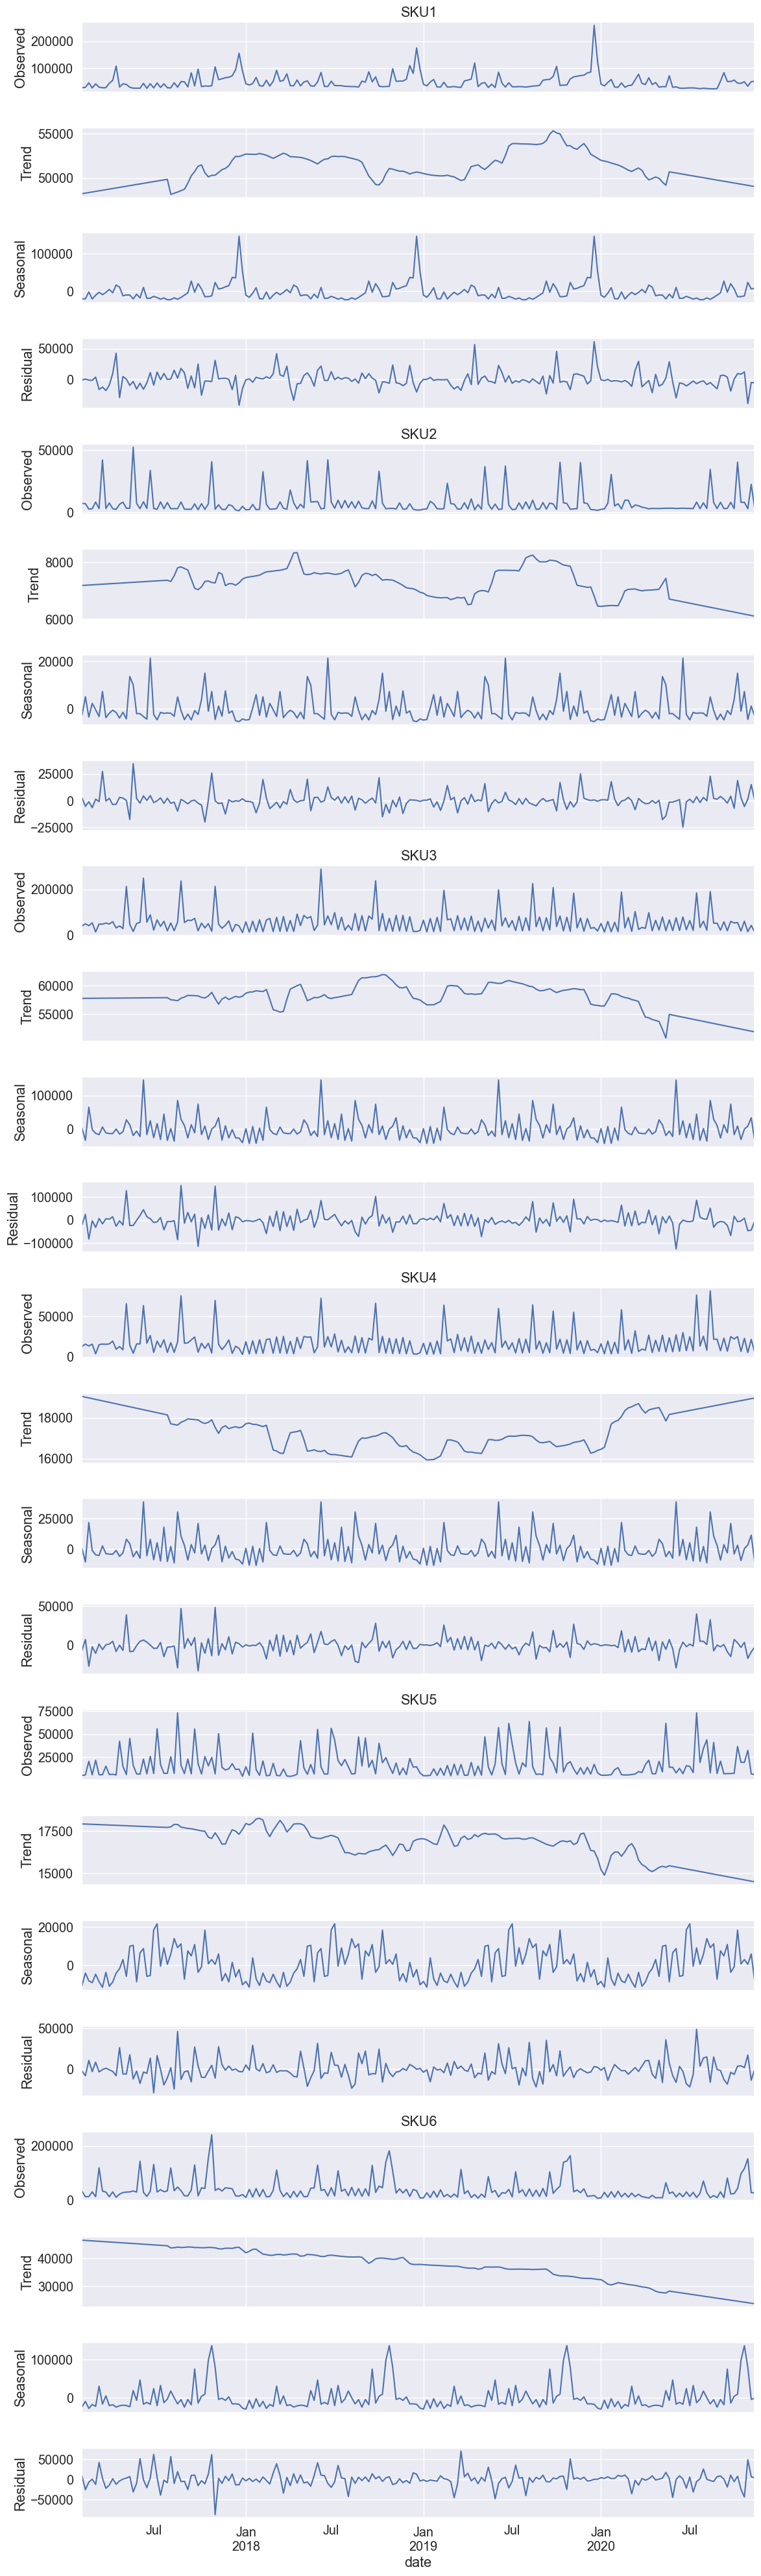

In [214]:
fig, ax = plt.subplots(ncols=1, nrows=24, sharex = True, figsize = (12, 40))


for i, (key, sku) in enumerate(skus.items()):
    seasonal_decompose(sku.Sales, ax, i, key)


plt.tight_layout()
plt.show()

### 2.5 Stationarity

In [215]:
# plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, label):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= label)
    ax.set_title(label)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    ax.legend()

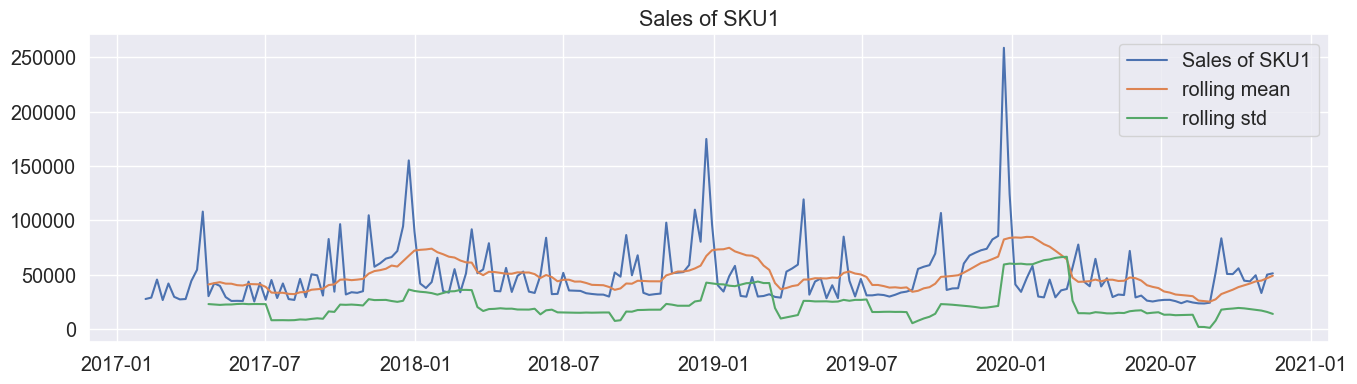

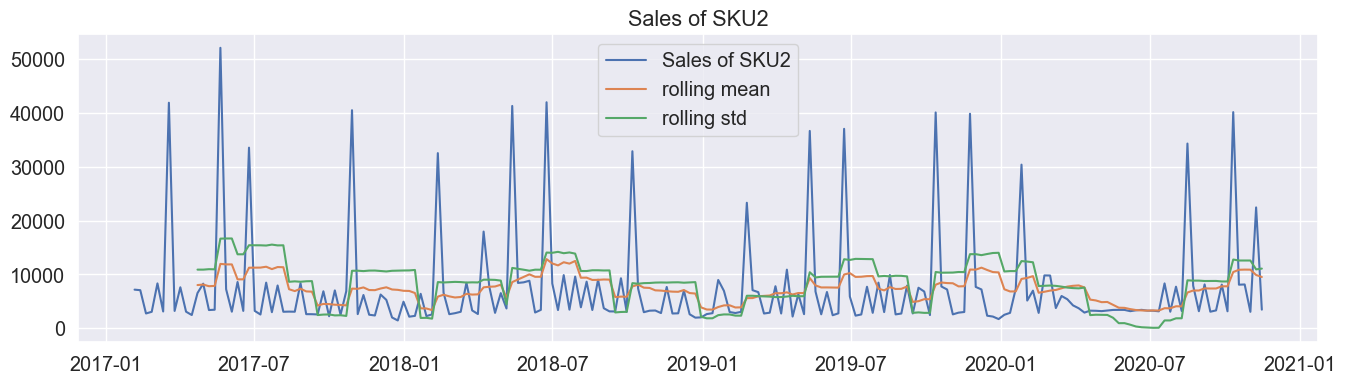

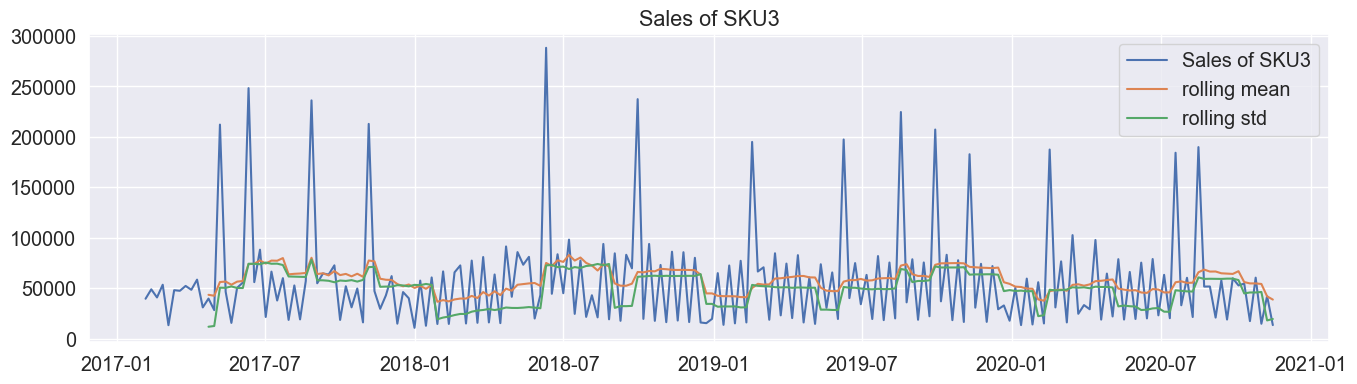

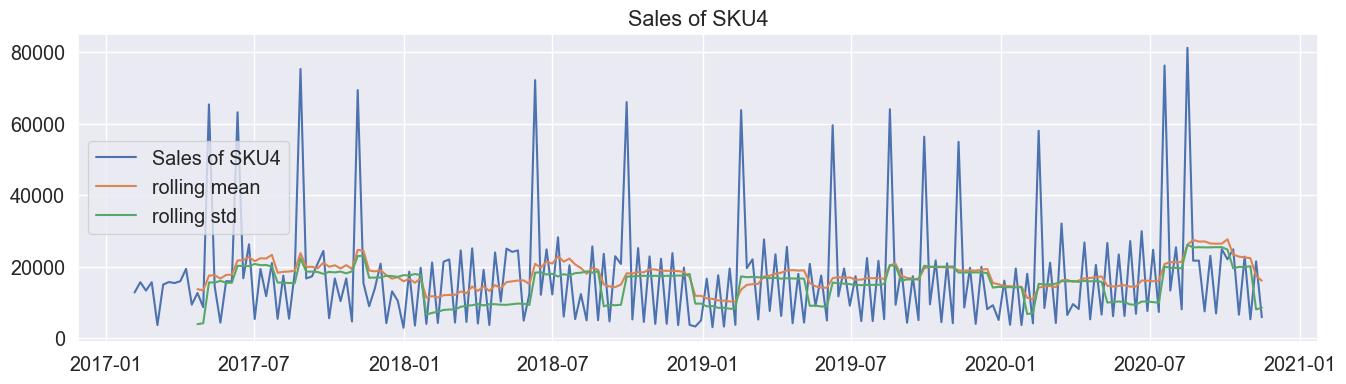

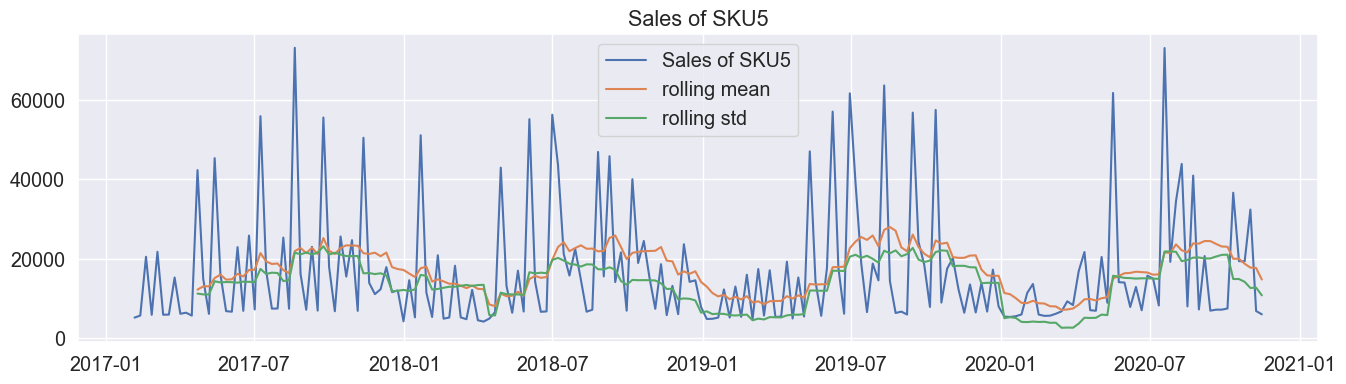

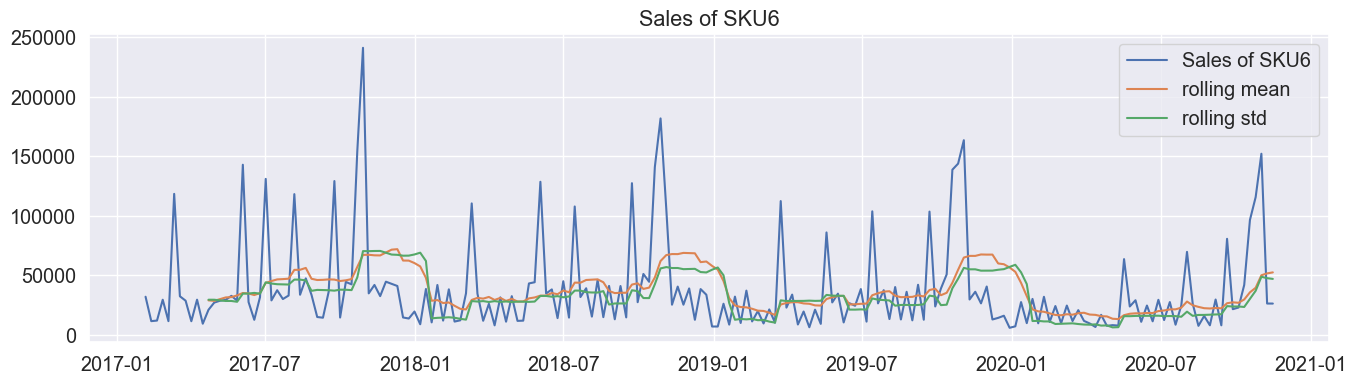

In [216]:
pd.options.display.float_format = '{:.8f}'.format
for key, sku in skus.items():
    test_stationarity(sku.Sales, "Sales of " + key.upper() )

In [217]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [218]:
for key, sku in skus.items():
    ADF_test(sku.Sales, "Sales of " + key.upper())

 > Is the Sales of SKU1 stationary ?
Test statistic = -9.083
P-value = 0.000
Critical values :
	1%: -3.463987334463603 - The data is  stationary with 99% confidence
	5%: -2.8763259091636213 - The data is  stationary with 95% confidence
	10%: -2.5746515171738515 - The data is  stationary with 90% confidence
 > Is the Sales of SKU2 stationary ?
Test statistic = -15.166
P-value = 0.000
Critical values :
	1%: -3.463987334463603 - The data is  stationary with 99% confidence
	5%: -2.8763259091636213 - The data is  stationary with 95% confidence
	10%: -2.5746515171738515 - The data is  stationary with 90% confidence
 > Is the Sales of SKU3 stationary ?
Test statistic = -3.145
P-value = 0.023
Critical values :
	1%: -3.4668001583460613 - The data is not stationary with 99% confidence
	5%: -2.8775552336674317 - The data is  stationary with 95% confidence
	10%: -2.5753075498128246 - The data is  stationary with 90% confidence
 > Is the Sales of SKU4 stationary ?
Test statistic = -6.287
P-value = 

From the Dickey Fuller test, we know that the Sales data at for all 6 SKUs are stationary.

### 2.6 Periodogram

In [219]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("52W") / pd.Timedelta("1W")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

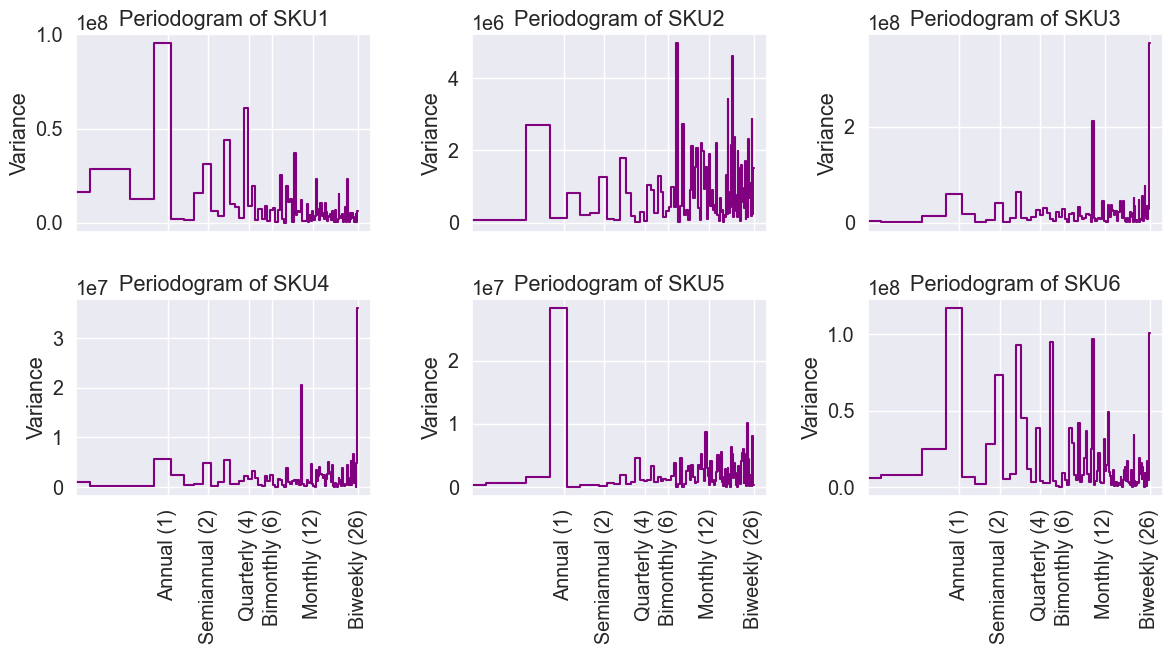

In [220]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7), sharex = True)
for i, (key, sku) in enumerate(skus.items()):
    plot_periodogram(sku.Sales, ax = ax[i//3][i%3])
    ax[i//3][i%3].set_title(f"Periodogram of {key.upper()}")
    
fig.tight_layout()

## 3. Features engineering

### 3.1 Lagging

In [221]:
# function to create a lagplot
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

# functions to plot the lagplot
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


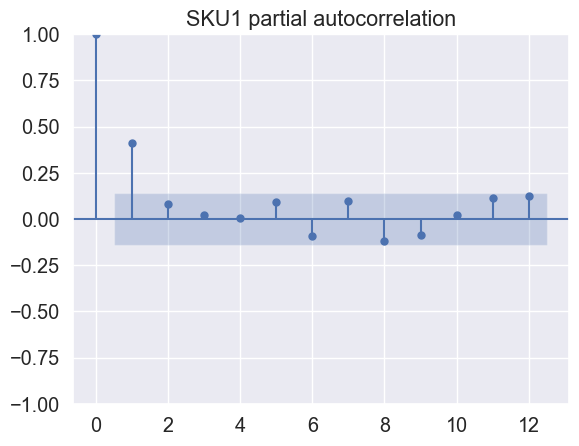

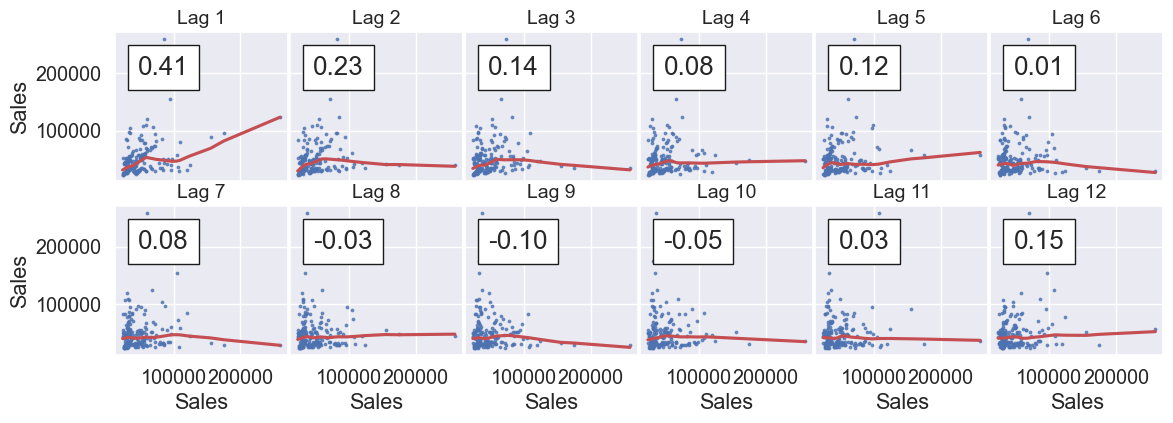

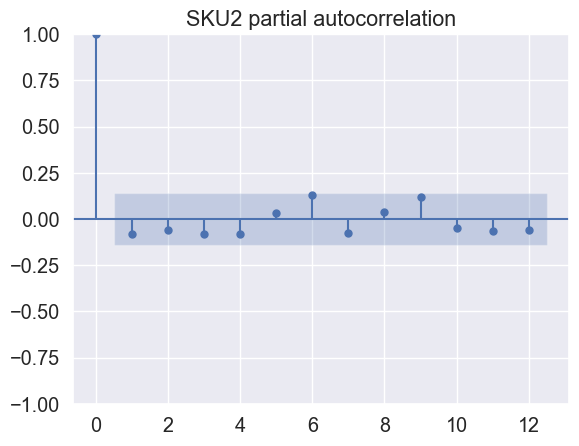

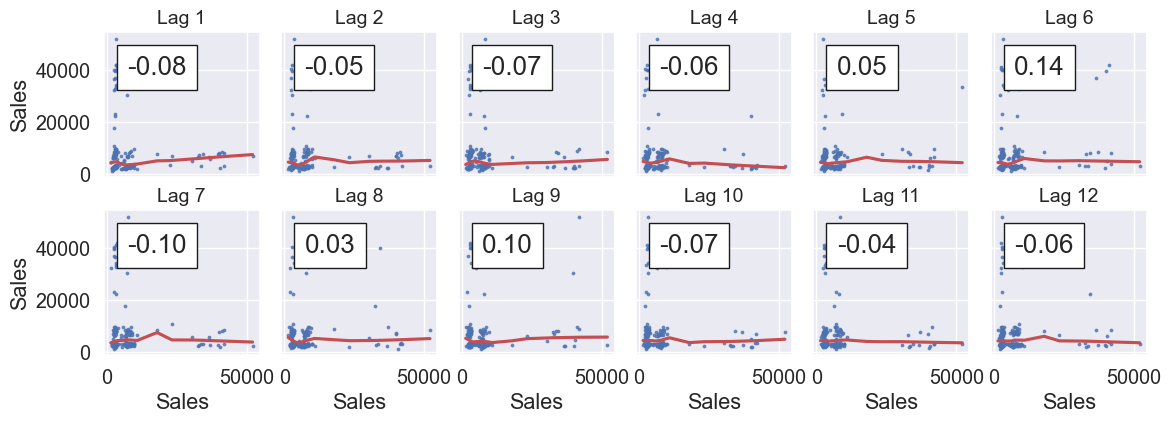

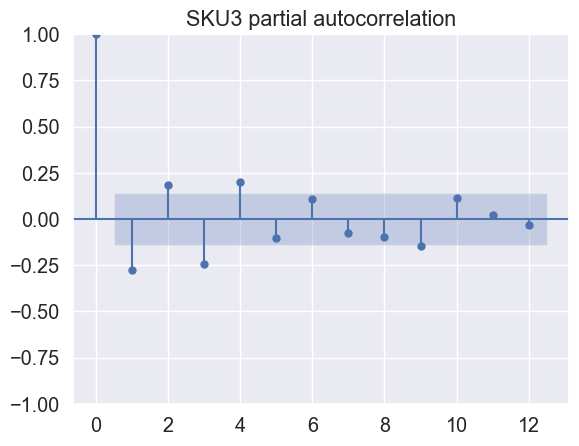

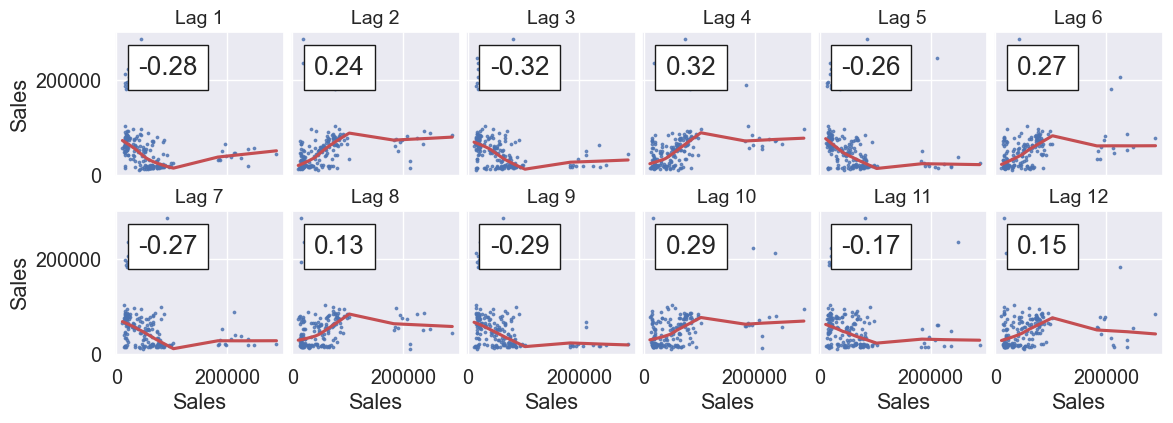

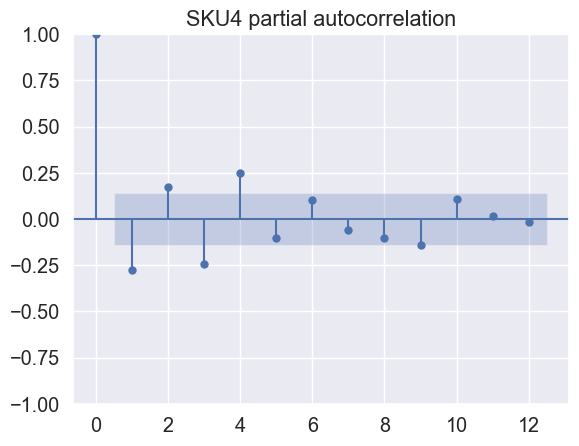

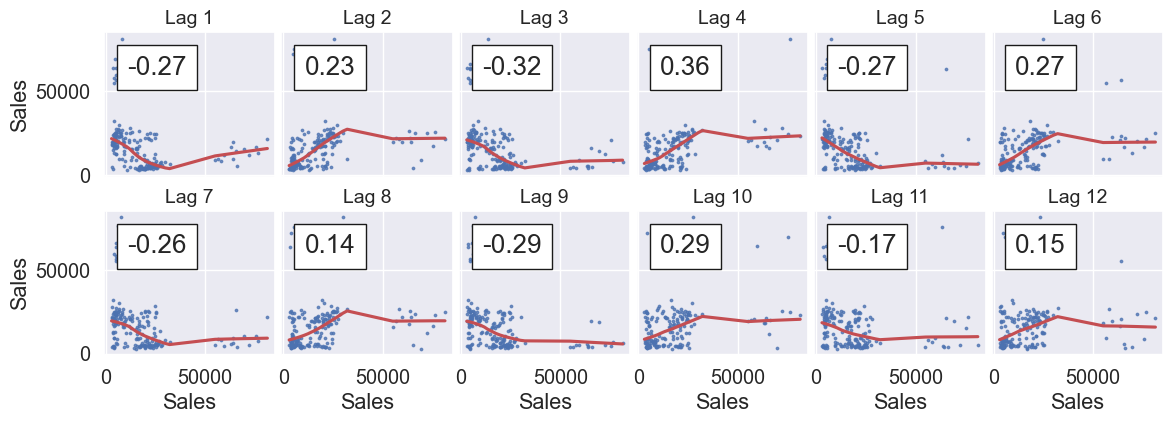

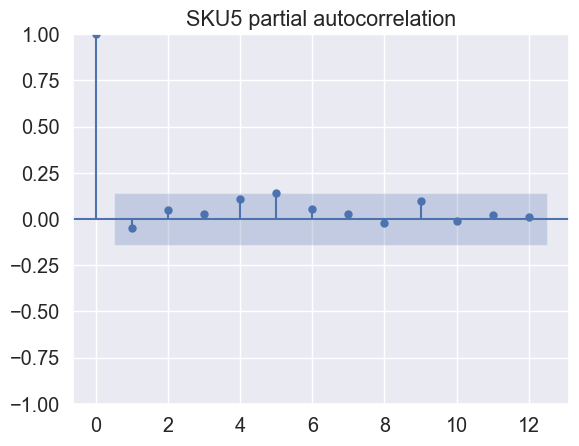

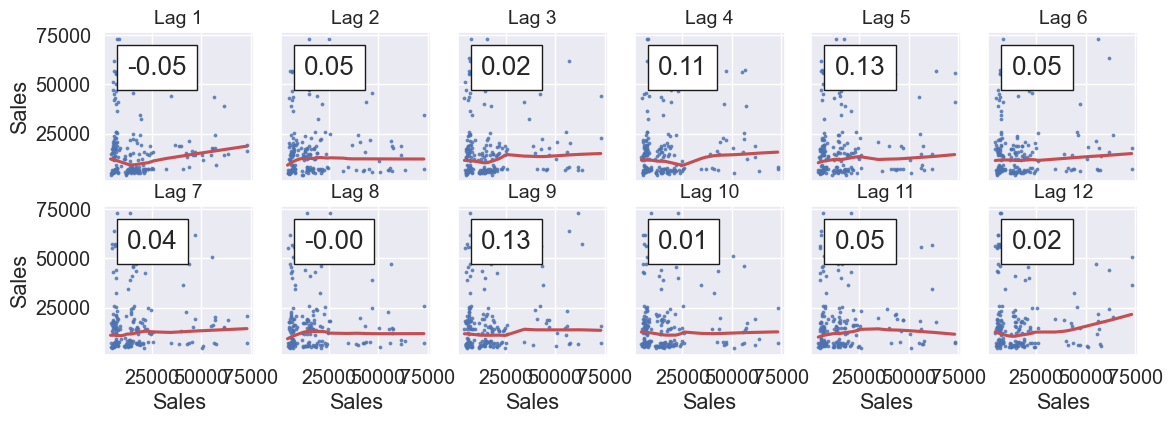

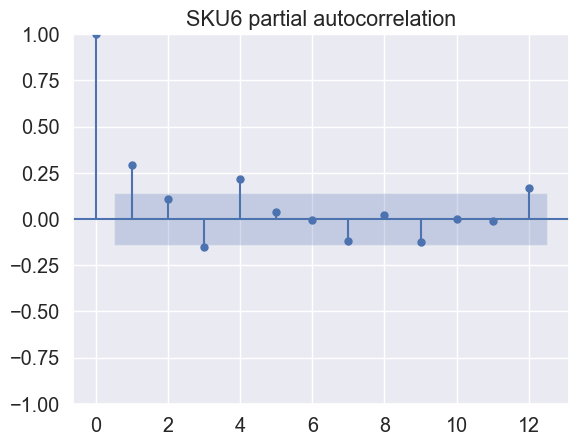

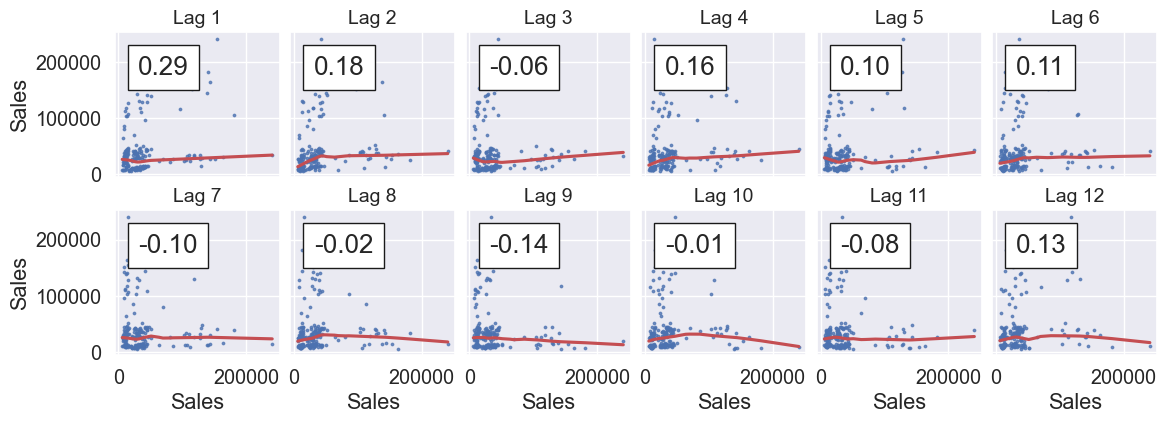

In [222]:

for key, sku in skus.items():
    _ = plot_pacf(sku.Sales, lags=12, title = f"{key.upper()} partial autocorrelation")
    _ = plot_lags(sku.Sales, lags=12, nrows=2)
    
   

In [223]:
# function to make lags
def make_lags(ts, lags):
    X = pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)
    X = X.fillna(0.0)
    return X

In [233]:
skus['sku1'] = skus['sku1'].merge(make_lags(skus['sku1'].Sales, 1), left_index = True, right_index = True)

skus['sku3'] = skus['sku3'].merge(make_lags(skus['sku3'].Sales, 4), left_index = True, right_index = True)

skus['sku4'] = skus['sku4'].merge(make_lags(skus['sku4'].Sales, 4), left_index = True, right_index = True)

skus['sku6'] = skus['sku6'].merge(make_lags(skus['sku6'].Sales, 1), left_index = True, right_index = True)



### 3.2 Train test split

In [234]:
def train_val_split(skus):
    X_train_skus = {}
    X_val_skus = {}
    y_train_skus = {}
    y_val_skus = {}

    for key, sku in skus.items():

        y = sku.Sales
        X = sku.drop(['Sales', 'Product'], axis = 1)
        size = int(len(X)*0.7)


        X_train, X_val, y_train, y_val =  X[:size], X[size:], y[:size], y[size:]

        X_train_skus[key] = X_train
        X_val_skus[key] = X_val
        y_train_skus[key] = y_train
        y_val_skus[key] = y_val
    return X_train_skus, X_val_skus, y_train_skus, y_val_skus
    



In [235]:
X_train_skus, X_val_skus, y_train_skus, y_val_skus = train_val_split(skus)

### 3.3 Trend and seasonality features

In [236]:
# function to add the trend and seasonality feature to the data
def add_trend_n_season(df_train, df_val, order=0, seasonal = False, fourier = None):
    if fourier:
        dp = DeterministicProcess(
            index=df_train.index,
            constant=True,               
            order=order,                     
            seasonal=seasonal, 
            additional_terms=[fourier],
            drop=True,                 
        )
    else:
        dp = DeterministicProcess(
            index=df_train.index,
            constant=True,               
            order=order,                     
            seasonal=seasonal, 
#             additional_terms=[fourier],
            drop=True,                 
        )
    ts_train = dp.in_sample()
    X_train = pd.merge(df_train, ts_train, left_index=True, right_index = True)
    
    ts_val = dp.out_of_sample(steps=len(df_val), forecast_index = df_val.index)
    X_val = pd.merge(df_val, ts_val, left_index=True, right_index = True)
    return X_train, X_val

## 4. Model training

### 4.1 Linear Regression

In [237]:
modified_train = {}
modified_val = {}

for key, train_sku in X_train_skus.items():
    val_sku = X_val_skus[key]
    modified_train[key], modified_val[key] = add_trend_n_season(train_sku, val_sku, 0)
    


In [238]:
def plot_forcast(key, y, X_train, y_train, X_val, y_val, ax=None):
    
    
    model = LinearRegression(fit_intercept=False)
    _ = model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_train), index=y_train.index)
    y_fore = pd.Series(model.predict(X_val), index=y_val.index)
    if ax is None:
        _, ax = plt.subplots()
        
    error = mean_squared_error(y_val, y_fore)
    title = f"{key} | MSE: {round(error)}"
        
    ax = y.plot(color='k', style='.',title= title, ax= ax, label = 'Sales')
    ax = y_pred.plot(color='b', ax= ax, label= 'Trend and Seasonal')
    ax = y_fore.plot(label="Forecast", ax = ax, color = 'r')
    
    _ = ax.legend()
    
        
    
    return ax

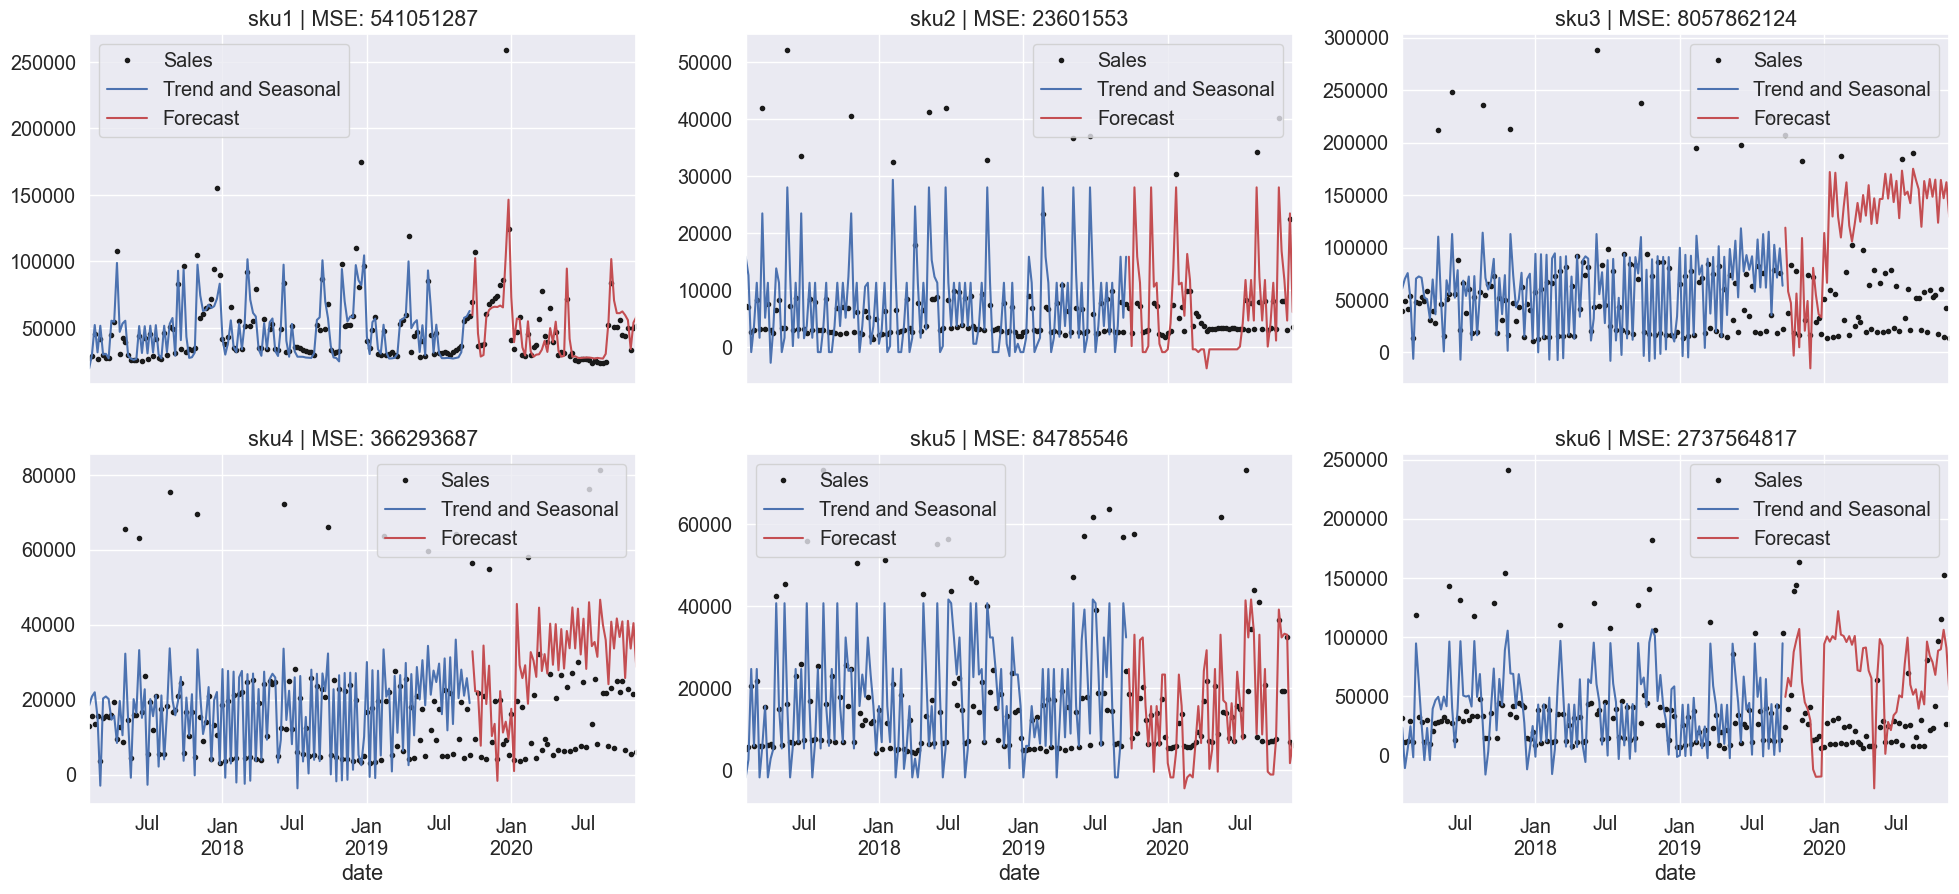

In [239]:
fig, ax = plt.subplots(2,3 , figsize=(24,10), sharex = True)

for i, (key, X_train_sku) in enumerate(modified_train.items()):
    
    X_val_sku = modified_val[key]
    y_train_sku = y_train_skus[key]
    y_val_sku = y_val_skus[key]
    plot_forcast(key, skus[key].Sales, 
                 X_train_sku, 
                y_train_sku,
                X_val_sku,
                y_val_sku,
                ax = ax[i // 3][i % 3])
    


### 4.2 Hyperparameters tuning

From part 2.4 and 2.6, we observed some seasonality feature of different SKUs. We could tune the hyperparameters to match with different datasets

In [240]:
modified_train_tune = {}
modified_val_tune = {}

trends = [2, 0, 0, 2, 0, 1]

fourier = CalendarFourier(freq="A", order=10)

for order, (key, train_sku) in zip(trends, X_train_skus.items()):
    val_sku = X_val_skus[key]
    if key[3] == '2' or key[3]=='5':
        modified_train_tune[key], modified_val_tune[key] = add_trend_n_season(train_sku, val_sku, order, fourier = None)
    else:
        modified_train_tune[key], modified_val_tune[key] = add_trend_n_season(train_sku, val_sku, order, fourier = fourier)

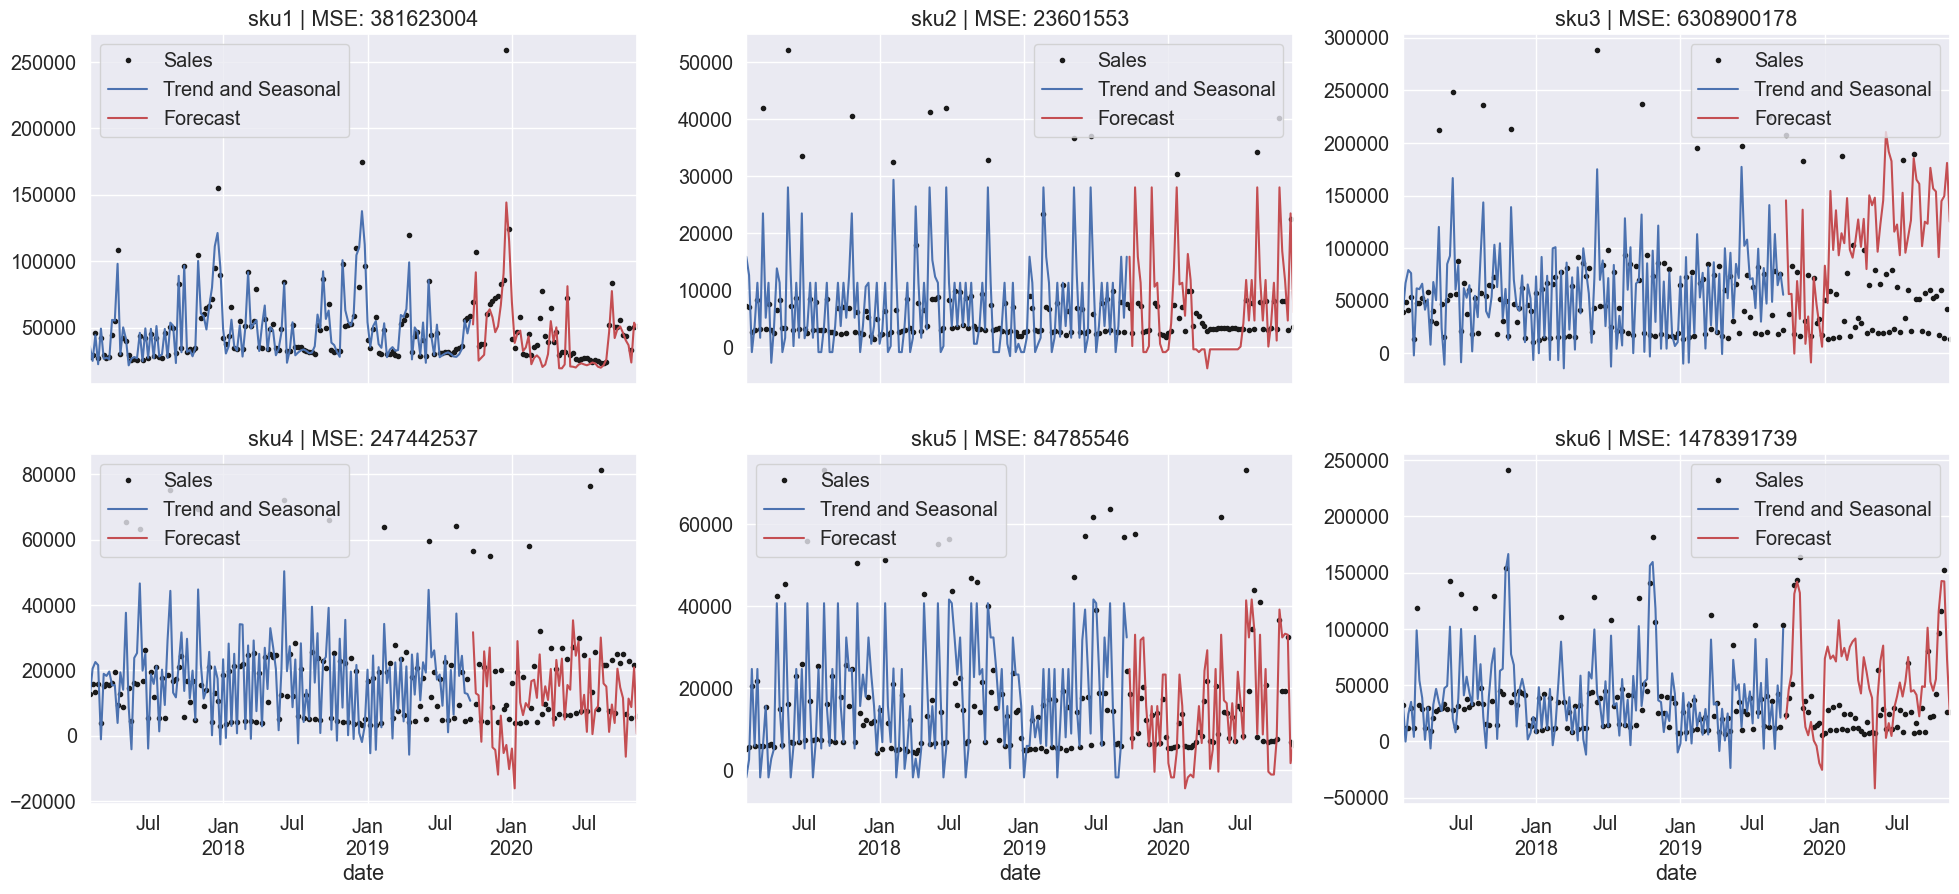

In [241]:
fig, ax = plt.subplots(2,3 , figsize=(24,10), sharex = True)

for i, (key, X_train_sku) in enumerate(modified_train_tune.items()):
    
    X_val_sku = modified_val_tune[key]
    y_train_sku = y_train_skus[key]
    y_val_sku = y_val_skus[key]
    plot_forcast(key, skus[key].Sales, 
                 X_train_sku, 
                y_train_sku,
                X_val_sku,
                y_val_sku,
                ax = ax[i // 3][i % 3])

The mean squared errors were reduced after tuning some hyperparameters